In [1]:
!pip install --user pandas matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np
import glob
import re

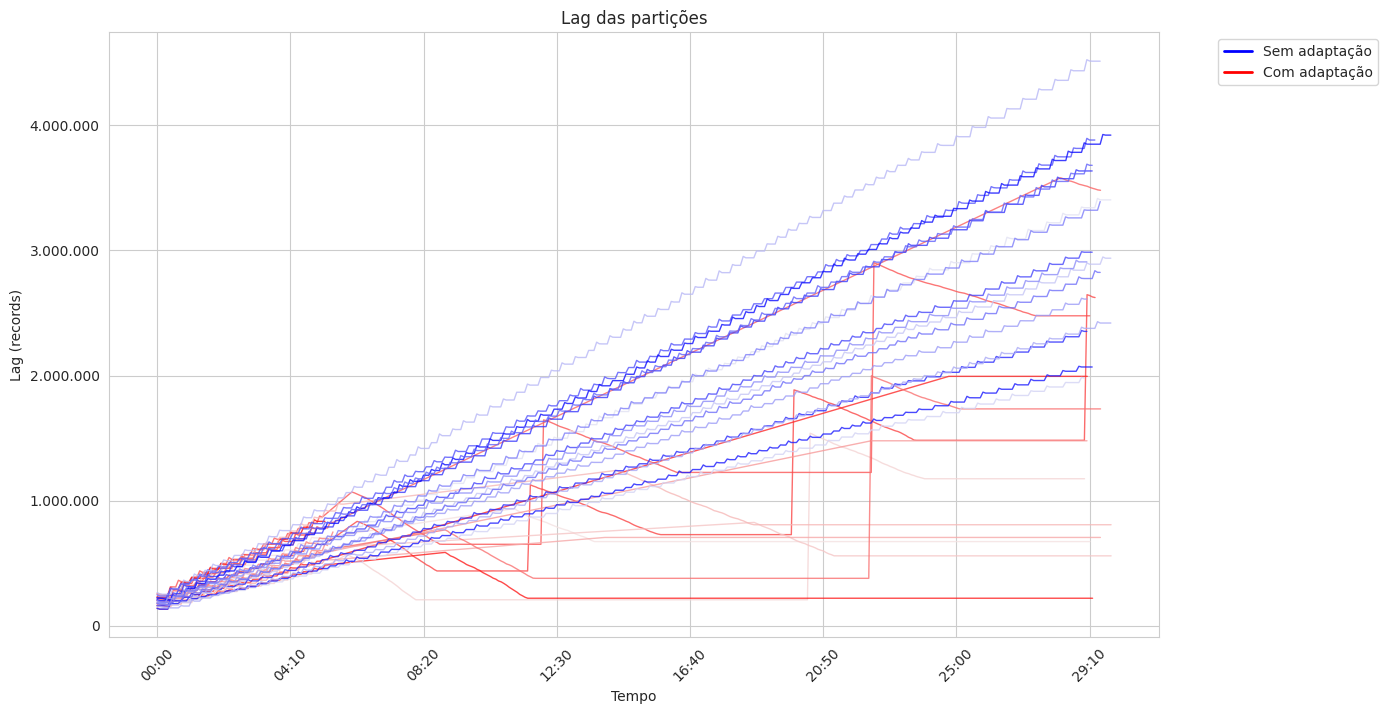

In [3]:
dfs = []
for i in range(0, 16):
    # Load maestro files
    maestro_file = f'scripts/docker/experiment/stats/maestro/metric-records-lag-vehicle-moviment-{i}.txt'
    df_maestro = pd.read_csv(maestro_file, sep=' ', header=None, names=['Timestamp', 'Value'])
    df_maestro['Timestamp'] = pd.to_datetime(df_maestro['Timestamp'], unit='ms')
    df_maestro['elapsed_seconds'] = (df_maestro['Timestamp'] - df_maestro['Timestamp'].iloc[0]).dt.total_seconds()
    df_maestro['source'] = 'maestro'
    df_maestro['series'] = f'maestro-{i}'
    dfs.append(df_maestro)
    
    # Load vanilla files
    vanilla_file = f'scripts/docker/experiment/stats/vanilla/metric-records-lag-vehicle-moviment-{i}.txt'
    df_vanilla = pd.read_csv(vanilla_file, sep=' ', header=None, names=['Timestamp', 'Value'])
    df_vanilla['Timestamp'] = pd.to_datetime(df_vanilla['Timestamp'], unit='ms')
    df_vanilla['elapsed_seconds'] = (df_vanilla['Timestamp'] - df_vanilla['Timestamp'].iloc[0]).dt.total_seconds()
    df_vanilla['source'] = 'vanilla'
    df_vanilla['series'] = f'vanilla-{i}'
    dfs.append(df_vanilla)

combined_df = pd.concat(dfs, ignore_index=True)

# Create custom color palettes
def create_shades(base_color, n_shades=16):
    """Generate n shades of a base color"""
    if base_color == 'blue':
        colors = sns.light_palette("blue", n_shades+2)[1:-1]  # Skip the lightest and darkest
    else:  # red
        colors = sns.light_palette("red", n_shades+2)[1:-1]
    return [colors[i] for i in range(n_shades)]

vanilla_colors = create_shades('blue')
maestro_colors = create_shades('red')

# Assign colors to each series
color_mapping = {}
for i in range(16):
    color_mapping[f'vanilla-{i}'] = vanilla_colors[i]
    color_mapping[f'maestro-{i}'] = maestro_colors[i]

# Plot settings
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Plot each series with its assigned color
for series, group in combined_df.groupby('series'):
    plt.plot(
        group['elapsed_seconds'],
        group['Value'],
        color=color_mapping[series],
        alpha=0.8,
        linewidth=1,
        label=series
    )

# Create proxy artists for legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Sem adaptação'),
    Line2D([0], [0], color='red',  lw=2, label='Com adaptação')
]

plt.title('Lag das partições')
plt.xlabel('Tempo')
plt.ylabel('Lag (records)')

def format_number(x, pos):
    return "{:,.0f}".format(x).replace(",", "X").replace(".", ",").replace("X", ".")

def format_seconds(x, pos):
    td = timedelta(seconds=x)
    minutes, seconds = divmod(int(td.total_seconds()), 60)
    return f"{minutes:02d}:{seconds:02d}"

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_number))
ax.xaxis.set_major_formatter(FuncFormatter(format_seconds))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

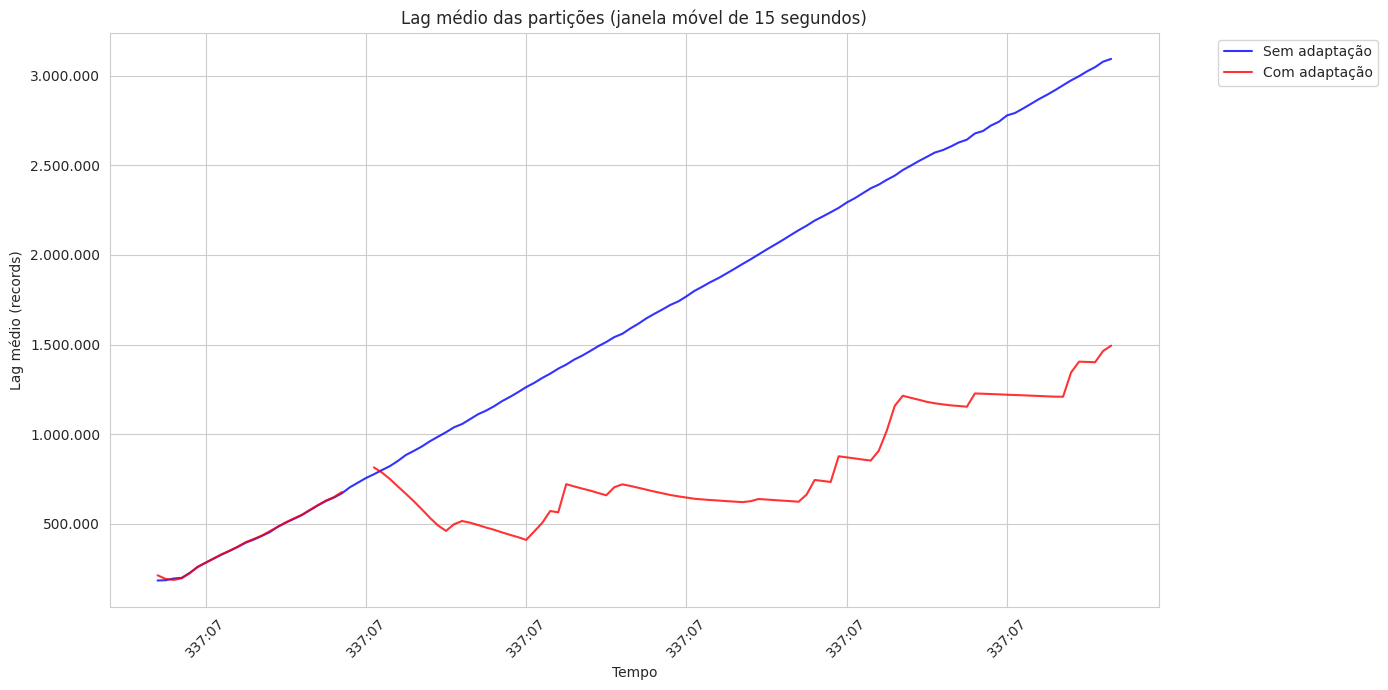

<Figure size 640x480 with 0 Axes>

In [4]:
# For visualization over time (rolling time-weighted average)
def rolling_time_weighted(df, window='15s'):
    df = df.sort_values('Timestamp').set_index('Timestamp')
    return df['Value'].resample(window).mean()  # Simple mean within each window

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Calculate and plot rolling averages
vanilla_rolling = rolling_time_weighted(combined_df[combined_df['source'] == 'vanilla'])
maestro_rolling = rolling_time_weighted(combined_df[combined_df['source'] == 'maestro'])

plt.plot(vanilla_rolling.index, vanilla_rolling.values, color='blue', label='Sem adaptação', alpha=0.8)
plt.plot(maestro_rolling.index, maestro_rolling.values, color='red', label='Com adaptação', alpha=0.8)

plt.title('Lag médio das partições (janela móvel de 15 segundos)')
plt.xlabel('Tempo')
plt.ylabel('Lag médio (records)')

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_number))
ax.xaxis.set_major_formatter(FuncFormatter(format_seconds))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("lag-medio.png")

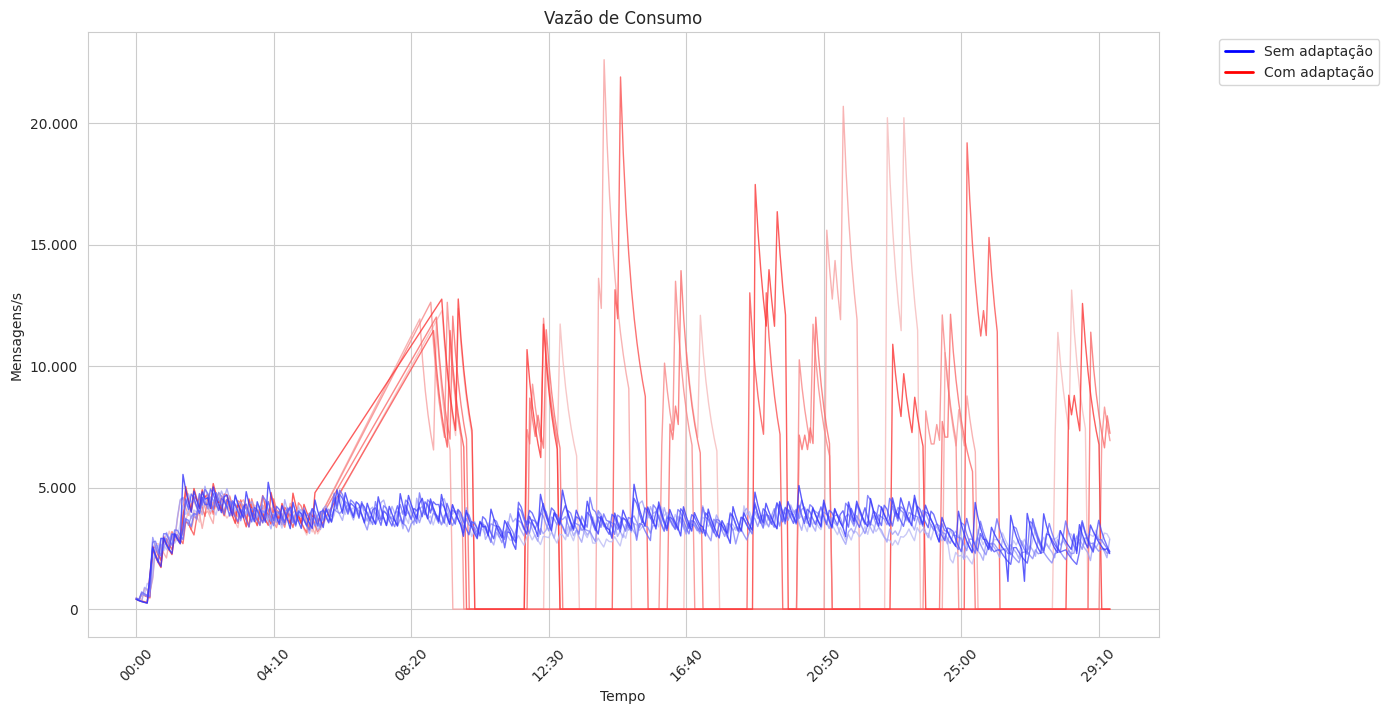

In [6]:
dfs = []
for maestro_file in glob.glob("scripts/docker/experiment/stats/maestro/metric-records-consumed-rate-vehicle-moviment-*"):
    match = re.search(r'(\d+)(?!.*\d)', maestro_file)
    i = 0
    if match:
        i = int(match.group(1))
    df_maestro = pd.read_csv(maestro_file, sep=' ', header=None, names=['Timestamp', 'Value'])
    df_maestro['Timestamp'] = pd.to_datetime(df_maestro['Timestamp'], unit='ms')
    df_maestro['elapsed_seconds'] = (df_maestro['Timestamp'] - df_maestro['Timestamp'].iloc[0]).dt.total_seconds()
    df_maestro['source'] = 'maestro'
    df_maestro['series'] = f'maestro-{i}'
    dfs.append(df_maestro)

for vanilla_file in glob.glob("scripts/docker/experiment/stats/vanilla/metric-records-consumed-rate-vehicle-moviment-*"):
    match = re.search(r'(\d+)(?!.*\d)', vanilla_file)
    i = 0
    if match:
        i = int(match.group(1))
    df_vanilla = pd.read_csv(vanilla_file, sep=' ', header=None, names=['Timestamp', 'Value'])
    df_vanilla['Timestamp'] = pd.to_datetime(df_vanilla['Timestamp'], unit='ms')
    df_vanilla['elapsed_seconds'] = (df_vanilla['Timestamp'] - df_vanilla['Timestamp'].iloc[0]).dt.total_seconds()
    df_vanilla['source'] = 'vanilla'
    df_vanilla['series'] = f'vanilla-{i}'
    dfs.append(df_vanilla)

combined_df = pd.concat(dfs, ignore_index=True)

# Create custom color palettes
def create_shades(base_color, n_shades=8):
    """Generate n shades of a base color"""
    if base_color == 'blue':
        colors = sns.light_palette("blue", n_shades+2)[1:-1]  # Skip the lightest and darkest
    else:  # red
        colors = sns.light_palette("red", n_shades+2)[1:-1]
    return [colors[i] for i in range(n_shades)]

vanilla_colors = create_shades('blue')
maestro_colors = create_shades('red')

# Assign colors to each series
color_mapping = {}
for i in range(8):
    color_mapping[f'vanilla-{i}'] = vanilla_colors[i]
    color_mapping[f'maestro-{i}'] = maestro_colors[i]

# Plot settings
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Plot each series with its assigned color
for series, group in combined_df.groupby('series'):
    plt.plot(
        group['elapsed_seconds'],
        group['Value'],
        color=color_mapping[series],
        alpha=0.8,
        linewidth=1,
        label=series
    )

# Create proxy artists for legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Sem adaptação'),
    Line2D([0], [0], color='red',  lw=2, label='Com adaptação')
]

plt.title('Vazão de Consumo')
plt.xlabel('Tempo')
plt.ylabel('Mensagens/s')

def format_number(x, pos):
    return "{:,.0f}".format(x).replace(",", "X").replace(".", ",").replace("X", ".")

def format_seconds(x, pos):
    td = timedelta(seconds=x)
    minutes, seconds = divmod(int(td.total_seconds()), 60)
    return f"{minutes:02d}:{seconds:02d}"

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_number))
ax.xaxis.set_major_formatter(FuncFormatter(format_seconds))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


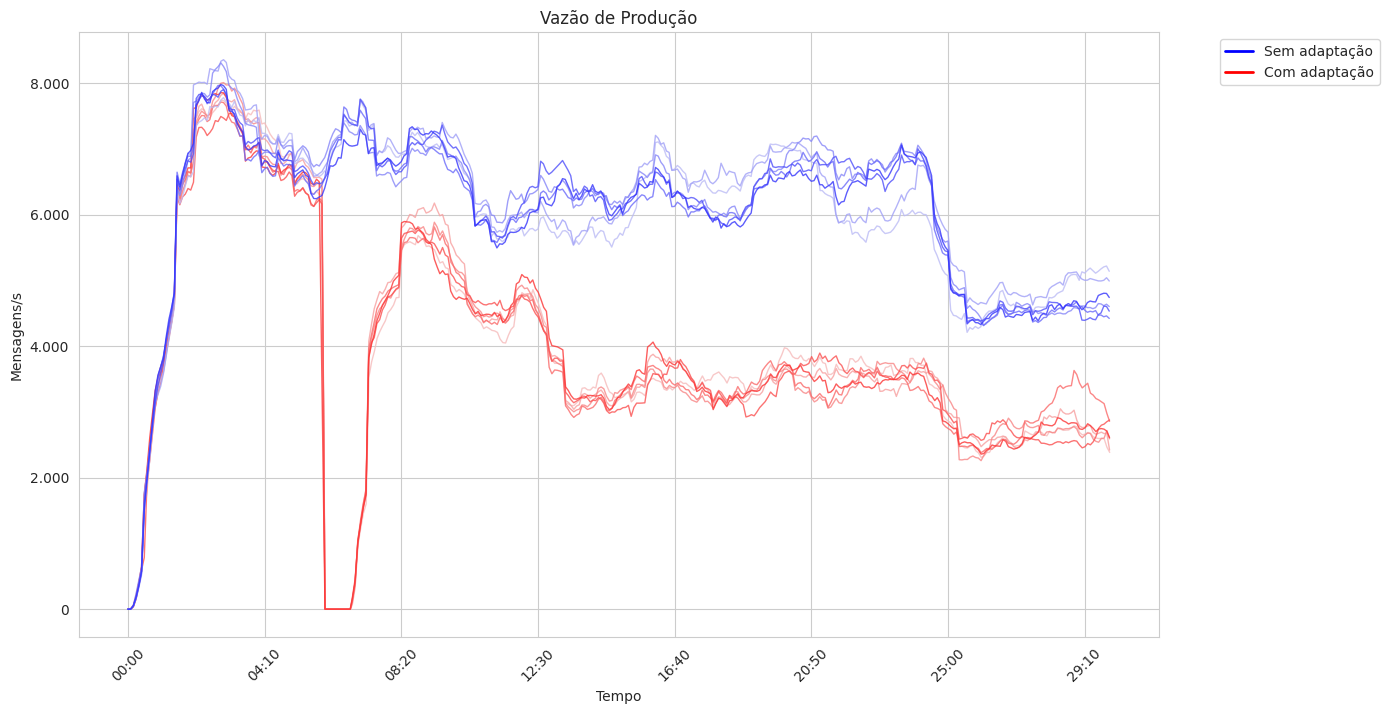

In [8]:
dfs = []
for maestro_file in glob.glob("scripts/docker/experiment/stats/maestro/metric-record-send-rate-*"):
    match = re.search(r'(\d+)(?!.*\d)', maestro_file)
    i = 0
    if match:
        i = int(match.group(1))
    df_maestro = pd.read_csv(maestro_file, sep=' ', header=None, names=['Timestamp', 'Value'])
    df_maestro['Timestamp'] = pd.to_datetime(df_maestro['Timestamp'], unit='ms')
    df_maestro['elapsed_seconds'] = (df_maestro['Timestamp'] - df_maestro['Timestamp'].iloc[0]).dt.total_seconds()
    df_maestro['source'] = 'maestro'
    df_maestro['series'] = f'maestro-{i}'
    dfs.append(df_maestro)

for vanilla_file in glob.glob("scripts/docker/experiment/stats/vanilla/metric-record-send-rate-*"):
    match = re.search(r'(\d+)(?!.*\d)', vanilla_file)
    i = 0
    if match:
        i = int(match.group(1))
    df_vanilla = pd.read_csv(vanilla_file, sep=' ', header=None, names=['Timestamp', 'Value'])
    df_vanilla['Timestamp'] = pd.to_datetime(df_vanilla['Timestamp'], unit='ms')
    df_vanilla['elapsed_seconds'] = (df_vanilla['Timestamp'] - df_vanilla['Timestamp'].iloc[0]).dt.total_seconds()
    df_vanilla['source'] = 'vanilla'
    df_vanilla['series'] = f'vanilla-{i}'
    dfs.append(df_vanilla)

combined_df = pd.concat(dfs, ignore_index=True)

# Create custom color palettes
def create_shades(base_color, n_shades=8):
    """Generate n shades of a base color"""
    if base_color == 'blue':
        colors = sns.light_palette("blue", n_shades+2)[1:-1]  # Skip the lightest and darkest
    else:  # red
        colors = sns.light_palette("red", n_shades+2)[1:-1]
    return [colors[i] for i in range(n_shades)]

vanilla_colors = create_shades('blue')
maestro_colors = create_shades('red')

# Assign colors to each series
color_mapping = {}
for i in range(8):
    color_mapping[f'vanilla-{i}'] = vanilla_colors[i]
    color_mapping[f'maestro-{i}'] = maestro_colors[i]

# Plot settings
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Plot each series with its assigned color
for series, group in combined_df.groupby('series'):
    plt.plot(
        group['elapsed_seconds'],
        group['Value'],
        color=color_mapping[series],
        alpha=0.8,
        linewidth=1,
        label=series
    )

# Create proxy artists for legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Sem adaptação'),
    Line2D([0], [0], color='red',  lw=2, label='Com adaptação')
]

plt.title('Vazão de Produção')
plt.xlabel('Tempo')
plt.ylabel('Mensagens/s')

def format_number(x, pos):
    return "{:,.0f}".format(x).replace(",", "X").replace(".", ",").replace("X", ".")

def format_seconds(x, pos):
    td = timedelta(seconds=x)
    minutes, seconds = divmod(int(td.total_seconds()), 60)
    return f"{minutes:02d}:{seconds:02d}"

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_number))
ax.xaxis.set_major_formatter(FuncFormatter(format_seconds))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()